Episode:  10 | Mean Train Rewards: 21.5 | Mean Test Rewards: 27.3 | Mean Abs Policy Loss: 0.31 | Mean Abs Value Loss: 0.35
Episode:  20 | Mean Train Rewards: 28.9 | Mean Test Rewards: 41.4 | Mean Abs Policy Loss: 0.38 | Mean Abs Value Loss: 0.36
Episode:  30 | Mean Train Rewards: 34.9 | Mean Test Rewards: 47.5 | Mean Abs Policy Loss: 0.44 | Mean Abs Value Loss: 0.36
Episode:  40 | Mean Train Rewards: 56.7 | Mean Test Rewards: 88.8 | Mean Abs Policy Loss: 0.92 | Mean Abs Value Loss: 0.36
Episode:  50 | Mean Train Rewards: 80.7 | Mean Test Rewards: 109.2 | Mean Abs Policy Loss: 1.11 | Mean Abs Value Loss: 0.38
Episode:  60 | Mean Train Rewards: 94.3 | Mean Test Rewards: 115.5 | Mean Abs Policy Loss: 1.17 | Mean Abs Value Loss: 0.35
Episode:  70 | Mean Train Rewards: 101.4 | Mean Test Rewards: 142.3 | Mean Abs Policy Loss: 1.09 | Mean Abs Value Loss: 0.33
Episode:  80 | Mean Train Rewards: 119.4 | Mean Test Rewards: 175.5 | Mean Abs Policy Loss: 1.24 | Mean Abs Value Loss: 0.34
Episode:  

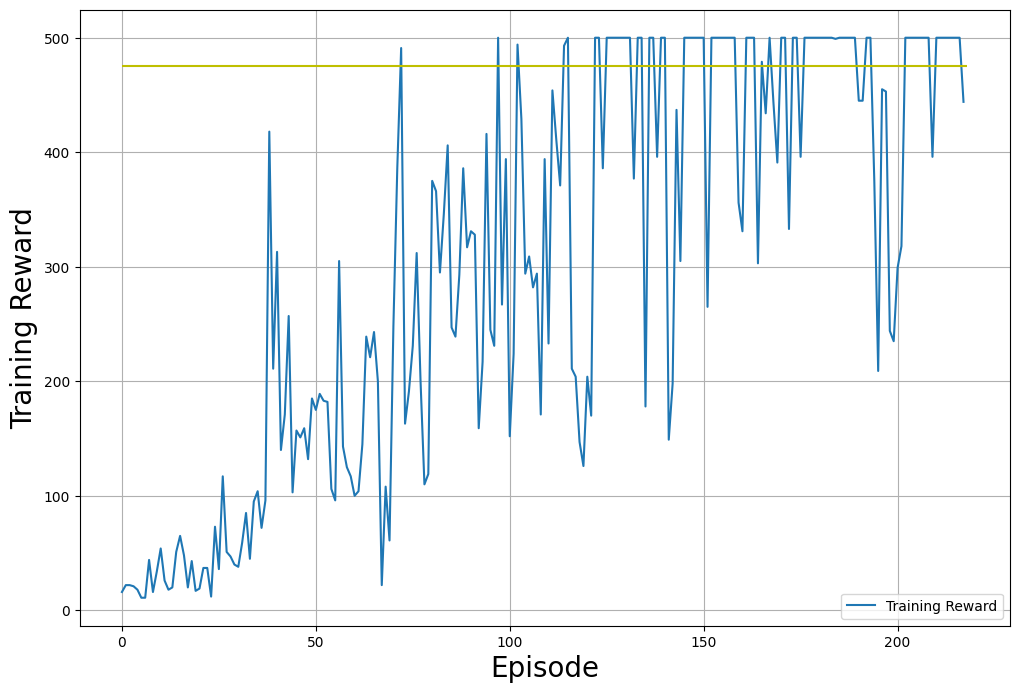

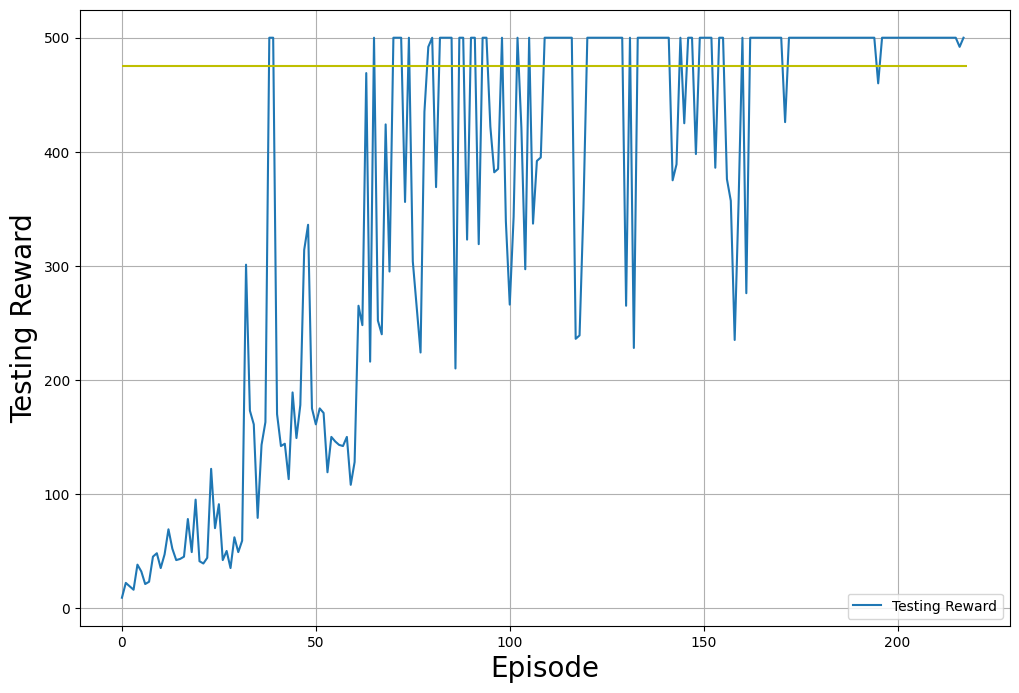

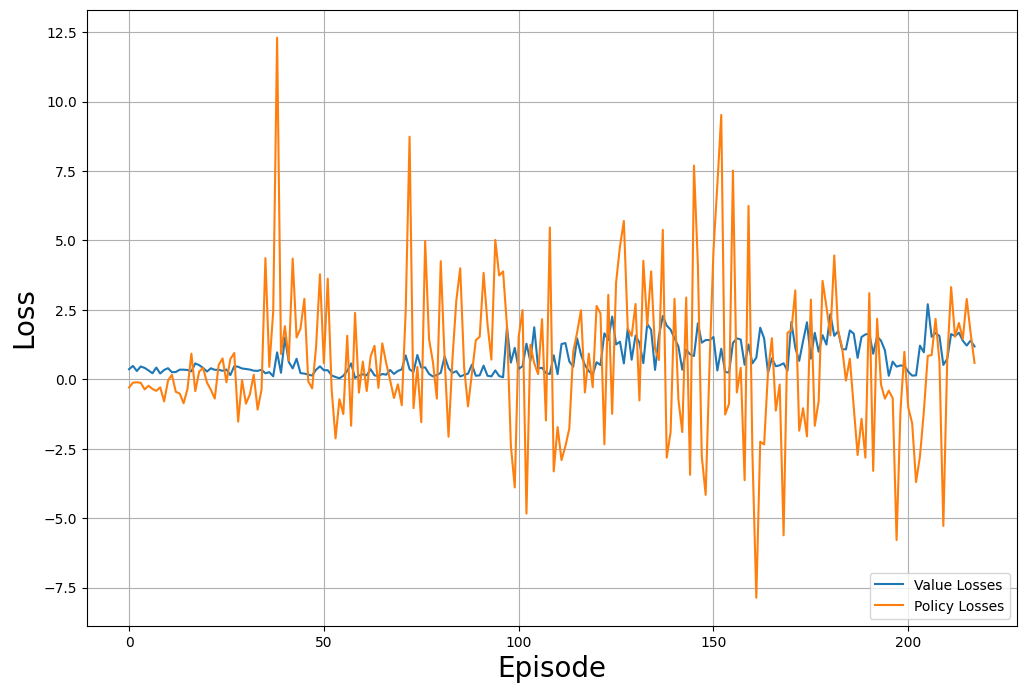

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as f
import torch.optim as optim
import torch.distributions as distributions
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
import gymnasium as gym
from tqdm import tqdm

# Create environments
env_train = gym.make("CartPole-v1")
env_test = gym.make("CartPole-v1")


# Define the backbone network
class BackboneNetwork(nn.Module):
    def __init__(self, in_features, hidden_dimensions, out_features, dropout):
        super().__init__()
        self.layer1 = nn.Linear(in_features, hidden_dimensions)
        self.layer2 = nn.Linear(hidden_dimensions, hidden_dimensions)
        self.layer3 = nn.Linear(hidden_dimensions, out_features)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.layer1(x)
        x = f.relu(x)
        x = self.dropout(x)
        x = self.layer2(x)
        x = f.relu(x)
        x = self.dropout(x)
        x = self.layer3(x)
        return x


# Define the actor-critic network
class ActorCritic(nn.Module):
    def __init__(self, actor, critic):
        super().__init__()
        self.actor = actor
        self.critic = critic

    def forward(self, state):
        action_pred = self.actor(state)
        value_pred = self.critic(state)
        return action_pred, value_pred


# Create agent function
def create_agent(hidden_dimensions, dropout):
    INPUT_FEATURES = env_train.observation_space.shape[0]
    HIDDEN_DIMENSIONS = hidden_dimensions
    ACTOR_OUTPUT_FEATURES = env_train.action_space.n
    CRITIC_OUTPUT_FEATURES = 1
    DROPOUT = dropout

    actor = BackboneNetwork(
        INPUT_FEATURES, HIDDEN_DIMENSIONS, ACTOR_OUTPUT_FEATURES, DROPOUT
    )
    critic = BackboneNetwork(
        INPUT_FEATURES, HIDDEN_DIMENSIONS, CRITIC_OUTPUT_FEATURES, DROPOUT
    )
    agent = ActorCritic(actor, critic)

    return agent


# Calculate returns
def calculate_returns(rewards, discount_factor):
    returns = []
    cumulative_reward = 0
    for r in reversed(rewards):
        cumulative_reward = r + cumulative_reward * discount_factor
        returns.insert(0, cumulative_reward)
    returns = torch.tensor(returns)
    # normalize the return
    returns = (returns - returns.mean()) / returns.std()
    return returns


# Calculate advantages
def calculate_advantages(returns, values):
    advantages = returns - values
    # Normalize the advantage
    advantages = (advantages - advantages.mean()) / advantages.std()
    return advantages


# Calculate surrogate loss
def calculate_surrogate_loss(
    actions_log_probability_old, actions_log_probability_new, epsilon, advantages
):

    advantages = advantages.detach()
    policy_ratio = (actions_log_probability_new - actions_log_probability_old).exp()
    surrogate_loss_1 = policy_ratio * advantages
    surrogate_loss_2 = (
        torch.clamp(policy_ratio, min=1.0 - epsilon, max=1.0 + epsilon) * advantages
    )
    surrogate_loss = torch.min(surrogate_loss_1, surrogate_loss_2)
    return surrogate_loss


# Calculate losses
def calculate_losses(surrogate_loss, entropy, entropy_coefficient, returns, value_pred):

    entropy_bonus = entropy_coefficient * entropy
    policy_loss = -(surrogate_loss + entropy_bonus).sum()
    value_loss = f.smooth_l1_loss(returns, value_pred).sum()
    return policy_loss, value_loss


# Initialize training
def init_training():
    states = []
    actions = []
    actions_log_probability = []
    values = []
    rewards = []
    done = False
    episode_reward = 0
    return (
        states,
        actions,
        actions_log_probability,
        values,
        rewards,
        done,
        episode_reward,
    )


# Forward pass
def forward_pass(env, agent, optimizer, discount_factor):
    states, actions, actions_log_probability, values, rewards, done, episode_reward = (
        init_training()
    )

    obs, info = env.reset()  # <-- capture obs and info
    agent.train()

    while not done:
        obs_tensor = torch.FloatTensor(obs).unsqueeze(0)
        states.append(obs_tensor)

        action_pred, value_pred = agent(obs_tensor)
        action_prob = f.softmax(action_pred, dim=-1)
        dist = distributions.Categorical(action_prob)
        action = dist.sample()
        log_prob_action = dist.log_prob(action)

        # Step environment: capture terminated & truncated
        obs, reward, terminated, truncated, info = env.step(action.item())
        done = terminated or truncated

        actions.append(action)
        actions_log_probability.append(log_prob_action)
        values.append(value_pred)
        rewards.append(reward)
        episode_reward += reward

    states = torch.cat(states)
    actions = torch.cat(actions)
    actions_log_probability = torch.cat(actions_log_probability)
    values = torch.cat(values).squeeze(-1)

    returns = calculate_returns(rewards, discount_factor)
    advantages = calculate_advantages(returns, values)

    return episode_reward, states, actions, actions_log_probability, advantages, returns


# Update policy
def update_policy(
    agent,
    states,
    actions,
    actions_log_probability_old,
    advantages,
    returns,
    optimizer,
    ppo_steps,
    epsilon,
    entropy_coefficient,
):

    BATCH_SIZE = 128
    total_policy_loss = 0
    total_value_loss = 0

    actions_log_probability_old = actions_log_probability_old.detach()
    actions = actions.detach()

    training_results_dataset = TensorDataset(
        states, actions, actions_log_probability_old, advantages, returns
    )

    batch_dataset = DataLoader(
        training_results_dataset, batch_size=BATCH_SIZE, shuffle=False
    )

    for _ in tqdm(range(ppo_steps)):
        for batch_idx, (
            states,
            actions,
            actions_log_probability_old,
            advantages,
            returns,
        ) in enumerate(batch_dataset):

            # get new log prob of actions for all input states
            action_pred, value_pred = agent(states)
            value_pred = value_pred.squeeze(-1)
            action_prob = f.softmax(action_pred, dim=-1)
            probability_distribution_new = distributions.Categorical(action_prob)
            entropy = probability_distribution_new.entropy()

            # estimate new log probabilities using old actions
            actions_log_probability_new = probability_distribution_new.log_prob(actions)

            surrogate_loss = calculate_surrogate_loss(
                actions_log_probability_old,
                actions_log_probability_new,
                epsilon,
                advantages,
            )

            policy_loss, value_loss = calculate_losses(
                surrogate_loss, entropy, entropy_coefficient, returns, value_pred
            )

            optimizer.zero_grad()
            policy_loss.backward()
            value_loss.backward()
            optimizer.step()

            total_policy_loss += policy_loss.item()
            total_value_loss += value_loss.item()

    return total_policy_loss / ppo_steps, total_value_loss / ppo_steps


# Evaluate
def evaluate(env, agent):
    agent.eval()
    done = False
    episode_reward = 0
    obs, info = env.reset()  # <-- capture obs and info 
    state = obs
    while not done:
        state = torch.FloatTensor(state).unsqueeze(0)
        with torch.no_grad():
            action_pred, _ = agent(state)
            action_prob = f.softmax(action_pred, dim=-1)
            action = torch.argmax(action_prob, dim=-1)
            state, reward, terminated, truncated, info = env.step(action.item())
            done = terminated or truncated
            episode_reward += reward

    return episode_reward


# Plot functions
def plot_train_rewards(train_rewards, reward_threshold):
    plt.figure(figsize=(12, 8))
    plt.plot(train_rewards, label="Training Reward")
    plt.xlabel("Episode", fontsize=20)
    plt.ylabel("Training Reward", fontsize=20)
    plt.hlines(reward_threshold, 0, len(train_rewards), color="y")
    plt.legend(loc="lower right")
    plt.grid()
    plt.show()


def plot_test_rewards(test_rewards, reward_threshold):
    plt.figure(figsize=(12, 8))
    plt.plot(test_rewards, label="Testing Reward")
    plt.xlabel("Episode", fontsize=20)
    plt.ylabel("Testing Reward", fontsize=20)
    plt.hlines(reward_threshold, 0, len(test_rewards), color="y")
    plt.legend(loc="lower right")
    plt.grid()
    plt.show()


def plot_losses(policy_losses, value_losses):
    plt.figure(figsize=(12, 8))
    plt.plot(value_losses, label="Value Losses")
    plt.plot(policy_losses, label="Policy Losses")
    plt.xlabel("Episode", fontsize=20)
    plt.ylabel("Loss", fontsize=20)
    plt.legend(loc="lower right")
    plt.grid()
    plt.show()


# Run PPO
def run_ppo():
    MAX_EPISODES = 500
    DISCOUNT_FACTOR = 0.99
    REWARD_THRESHOLD = 475
    PRINT_INTERVAL = 10
    PPO_STEPS = 8
    N_TRIALS = 100
    EPSILON = 0.2
    ENTROPY_COEFFICIENT = 0.01
    HIDDEN_DIMENSIONS = 64
    DROPOUT = 0.2
    LEARNING_RATE = 0.001

    train_rewards = []
    test_rewards = []
    policy_losses = []
    value_losses = []

    agent = create_agent(HIDDEN_DIMENSIONS, DROPOUT)
    optimizer = optim.Adam(agent.parameters(), lr=LEARNING_RATE)

    for episode in range(1, MAX_EPISODES + 1):
        train_reward, states, actions, actions_log_probability, advantages, returns = (
            forward_pass(env_train, agent, optimizer, DISCOUNT_FACTOR)
        )

        policy_loss, value_loss = update_policy(
            agent,
            states,
            actions,
            actions_log_probability,
            advantages,
            returns,
            optimizer,
            PPO_STEPS,
            EPSILON,
            ENTROPY_COEFFICIENT,
        )

        test_reward = evaluate(env_test, agent)

        policy_losses.append(policy_loss)
        value_losses.append(value_loss)
        train_rewards.append(train_reward)
        test_rewards.append(test_reward)

        mean_train_rewards = np.mean(train_rewards[-N_TRIALS:])
        mean_test_rewards = np.mean(test_rewards[-N_TRIALS:])
        mean_abs_policy_loss = np.mean(np.abs(policy_losses[-N_TRIALS:]))
        mean_abs_value_loss = np.mean(np.abs(value_losses[-N_TRIALS:]))

        if episode % PRINT_INTERVAL == 0:
            print(
                f"Episode: {episode:3} | \
Mean Train Rewards: {mean_train_rewards:3.1f} \
| Mean Test Rewards: {mean_test_rewards:3.1f} \
| Mean Abs Policy Loss: {mean_abs_policy_loss:2.2f} \
| Mean Abs Value Loss: {mean_abs_value_loss:2.2f}"
            )

        if mean_test_rewards >= REWARD_THRESHOLD:
            print(f"Reached reward threshold in {episode} episodes")
            break

    plot_train_rewards(train_rewards, REWARD_THRESHOLD)
    plot_test_rewards(test_rewards, REWARD_THRESHOLD)
    plot_losses(policy_losses, value_losses)


# Run the program
if __name__ == "__main__":
    run_ppo()

In [1]:
#!/usr/bin/env python
"""
End‑to‑end demo: PPO + LSTM policy on a premade Gym env (CartPole‑v1).

Dependencies
------------
pip install gymnasium stable-baselines3

Run
---
python ppo_lstm_cartpole.py
"""

import gymnasium as gym
from stable_baselines3 import PPO
from stable_baselines3.common.env_util import make_vec_env

# ---------------------------------------------------------------------
# 1) make a vectorised env (8 parallel workers speeds things up)
# ---------------------------------------------------------------------
env_id = "CartPole-v1"
num_envs = 8
vec_env = make_vec_env(env_id, n_envs=num_envs)

# ---------------------------------------------------------------------
# 2) create the PPO agent with an LSTM backbone
#    - "MlpLstmPolicy"   = shared MLP + LSTM + two heads (actor / critic)
#    - n_steps           = rollout length per env
#    - batch_size        = minibatch size for SGD
# ---------------------------------------------------------------------
model = PPO(
    policy="MlpLstmPolicy",
    env=vec_env,
    verbose=1,
    n_steps=128,  # 128 × 8 envs = 1024 steps/rollout
    batch_size=256,
    learning_rate=3e-4,
    gamma=0.99,
    gae_lambda=0.95,
    clip_range=0.2,
    n_epochs=4,
    ent_coef=0.01,
    vf_coef=0.5,
    max_grad_norm=0.5,
)

# ---------------------------------------------------------------------
# 3) train
# ---------------------------------------------------------------------
total_timesteps = 50_000  # ~50k / (8*128) ≈ 50 updates
model.learn(total_timesteps=total_timesteps)

# ---------------------------------------------------------------------
# 4) watch the trained agent (deterministic)
# ---------------------------------------------------------------------
env = gym.make(env_id, render_mode="human")
obs, _ = env.reset()
lstm_states = None  # hidden (h, c) tuples
done = False

for step in range(2_000):
    action, lstm_states = model.predict(
        obs,
        state=lstm_states,
        episode_start=done,
        deterministic=True,
    )
    obs, reward, done, truncated, _ = env.step(action)
    done = done or truncated
    if done:
        obs, _ = env.reset()
        lstm_states = None  # reset hidden state

env.close()

ValueError: Policy MlpLstmPolicy unknown

In [2]:
import numpy as np
from sb3_contrib import RecurrentPPO
from stable_baselines3.common.env_util import make_vec_env

# Create vectorized environment
env = make_vec_env("CartPole-v1", n_envs=1)

# Initialize the model
model = RecurrentPPO("MlpLstmPolicy", env, verbose=1)

# Train the model
model.learn(total_timesteps=5000)

# Save the model
model.save("recurrent_ppo_cartpole")

ModuleNotFoundError: No module named 'sb3_contrib'

In [ ]:
import numpy as np
from sb3_contrib import RecurrentPPO
from stable_baselines3.common.evaluation import evaluate_policy

# Initialize model
model = RecurrentPPO("MlpLstmPolicy", "CartPole-v1", verbose=1)

# TRAIN with interrupt handling
try:
    model.learn(5000)
except KeyboardInterrupt:
    print("⚠️ Training interrupted by user, saving partial model…")
    model.save("ppo_recurrent_interrupt")
else:
    # only save if completed normally
    model.save("ppo_recurrent")

# EVALUATE / ROLL OUT with interrupt handling
vec_env = model.get_env()
obs = vec_env.reset()
lstm_states = None
num_envs = vec_env.num_envs if hasattr(vec_env, "num_envs") else 1
episode_starts = np.ones((num_envs,), dtype=bool)

try:
    while True:
        action, lstm_states = model.predict(
            obs, state=lstm_states, episode_start=episode_starts, deterministic=True
        )
        obs, rewards, dones, info = vec_env.step(action)
        episode_starts = dones
        # vec_env.render("human")
except KeyboardInterrupt:
    print("⚠️ Rollout interrupted by user")
finally:
    vec_env.close()

Using cuda device
Creating environment from the given name 'CartPole-v1'
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 19.5     |
|    ep_rew_mean     | 19.5     |
| time/              |          |
|    fps             | 192      |
|    iterations      | 1        |
|    time_elapsed    | 0        |
|    total_timesteps | 128      |
---------------------------------
-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 19.4          |
|    ep_rew_mean          | 19.4          |
| time/                   |               |
|    fps                  | 162           |
|    iterations           | 2             |
|    time_elapsed         | 1             |
|    total_timesteps      | 256           |
| train/                  |               |
|    approx_kl            | 1.6525853e-05 |
|    clip_fraction        

In [3]:
from sb3_contrib.common.recurrent.policies import RecurrentActorCriticPolicy
from sb3_contrib import RecurrentPPO
import torch.nn as nn
import torch


class MyLSTMPolicy(RecurrentActorCriticPolicy):
    def __init__(self, observation_space, action_space, lr_schedule, **kw):
        super().__init__(
            observation_space, action_space, lr_schedule, net_arch=[], **kw
        )  # disable default MLP

        # ----- replace the default extractor / LSTM -------------
        hidden = 256
        self.lstm = nn.LSTM(
            self.features_dim, hidden, batch_first=True, num_layers=2, dropout=0.1
        )

        self.actor = nn.Linear(hidden, self.action_space.n)
        self.critic = nn.Linear(hidden, 1)

        # (Optional) freeze first LSTM layer for “partial fine‑tune”
        for p in self.lstm.parameters():
            p.requires_grad = False
        for p in self.lstm.parameters(recurse=False):
            p.requires_grad = True  # only top layer trainable

        # rebuild optimizer
        self._initialize_weights()


model = RecurrentPPO(
    policy=MyLSTMPolicy,
    env="CartPole-v1",
    learning_rate=3e-5,
    verbose=1,
)
model.learn(100_000)

Using cuda device
Creating environment from the given name 'CartPole-v1'
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


AttributeError: 'MyLSTMPolicy' object has no attribute '_initialize_weights'

In [2]:
import sys

print("sys.executable:", sys.executable)
print("sys.path:")
for p in sys.path:
    print("  ", p)
import sb3_contrib, os

pkg_dir = sb3_contrib.__path__[0]
print("sb3_contrib root:", pkg_dir)
print("common/ contents:", os.listdir(os.path.join(pkg_dir, "common")))

sys.executable: c:\Users\john\.pyenv\pyenv-win\versions\3.12.10\python.exe
sys.path:
   c:\Users\john\.pyenv\pyenv-win\versions\3.12.10\python312.zip
   c:\Users\john\.pyenv\pyenv-win\versions\3.12.10\DLLs
   c:\Users\john\.pyenv\pyenv-win\versions\3.12.10\Lib
   c:\Users\john\.pyenv\pyenv-win\versions\3.12.10
   
   c:\Users\john\.pyenv\pyenv-win\versions\3.12.10\Lib\site-packages
   c:\Users\john\.pyenv\pyenv-win\versions\3.12.10\Lib\site-packages\win32
   c:\Users\john\.pyenv\pyenv-win\versions\3.12.10\Lib\site-packages\win32\lib
   c:\Users\john\.pyenv\pyenv-win\versions\3.12.10\Lib\site-packages\Pythonwin
sb3_contrib root: c:\Users\john\.pyenv\pyenv-win\versions\3.12.10\Lib\site-packages\sb3_contrib
common/ contents: ['envs', 'maskable', 'recurrent', 'torch_layers.py', 'utils.py', 'vec_env', 'wrappers', '__init__.py', '__pycache__']
